#### Hodgkin-Huxley Model

The objective of this notebook is to:

1. Demonstrate how to implement continuous differential equations using the Euler or Runge-Kutta method.  
   The key idea is to discretize time and update the voltage \(V[i]\) by adding \(\Delta V \cdot dt\) at each step.

2. Simulate a simple time series of neuronal membrane potential.

3. Generate a phase space diagram to develop intuition for how spikes occur based on the Hodgkin-Huxley model.

4. Discuss the limitations of this model — such as computational complexity, lack of adaptation, and absence of spike heterogeneity.


In [1]:
import numpy as np
import matplotlib as plt

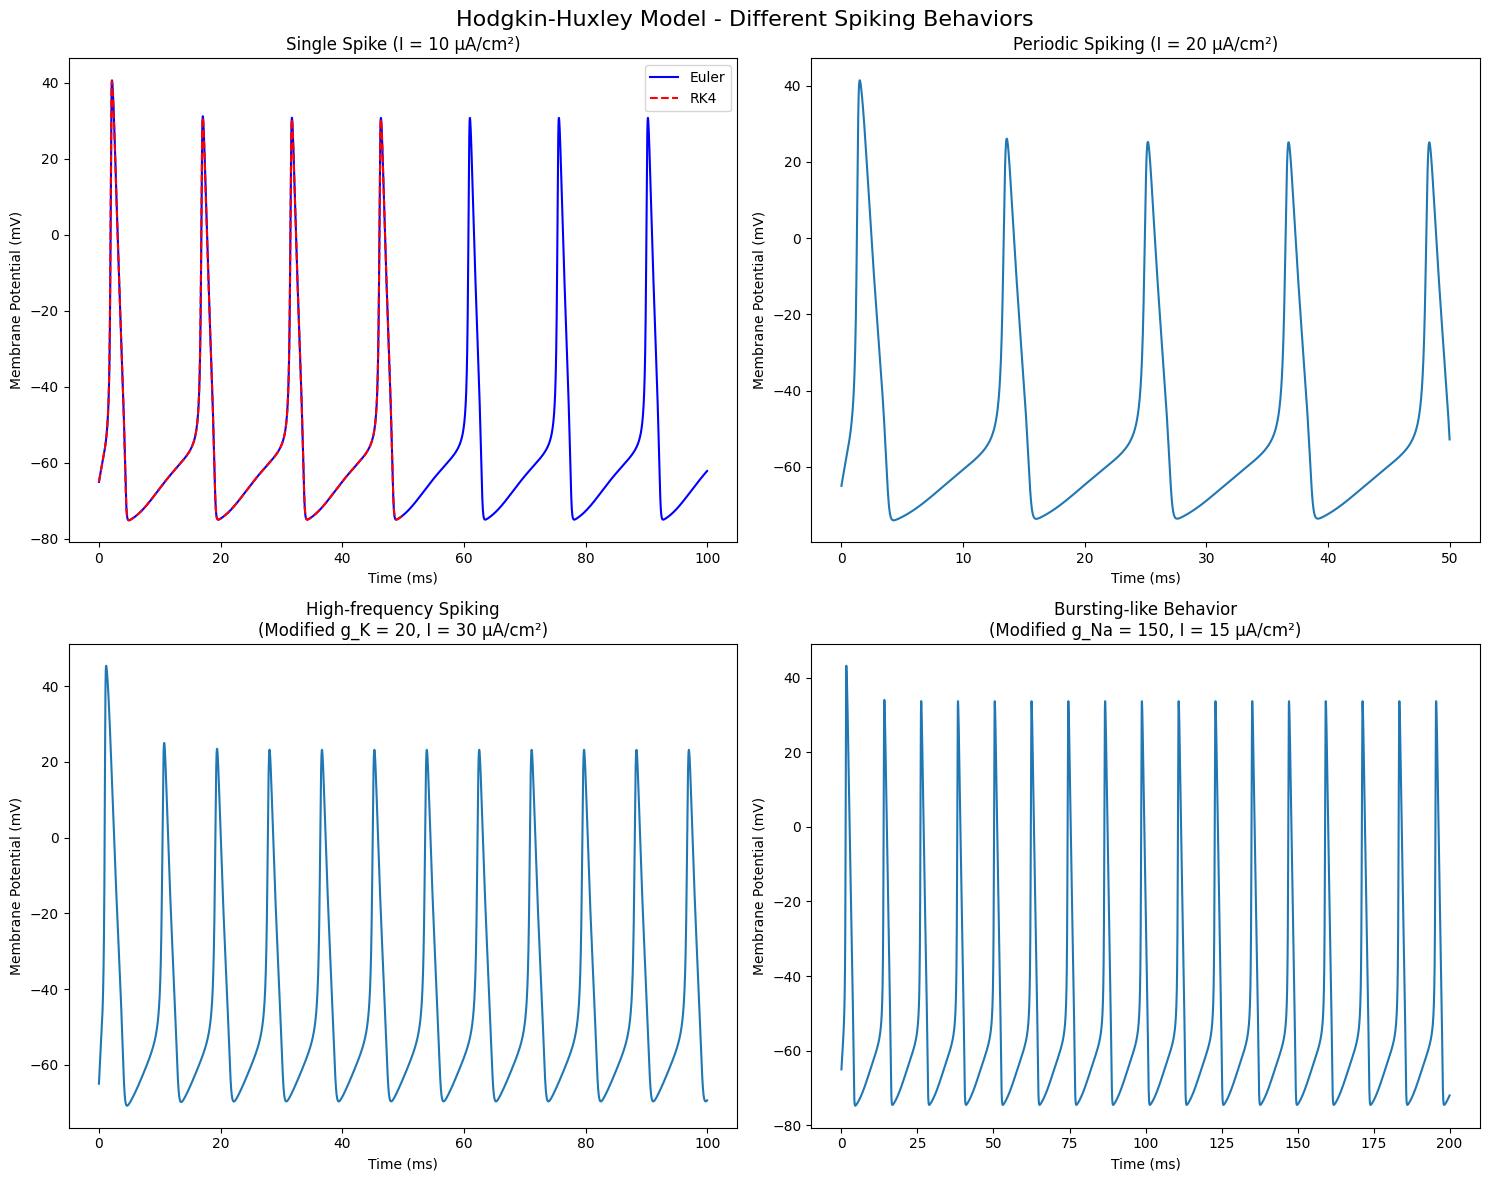

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Global parameters
C_m = 1.0      # Membrane capacitance (μF/cm²)
g_Na = 120.0   # Maximum sodium conductance (mS/cm²)
g_K = 36.0     # Maximum potassium conductance (mS/cm²)
g_L = 0.3      # Leak conductance (mS/cm²)
E_Na = 50.0    # Sodium reversal potential (mV)
E_K = -77.0    # Potassium reversal potential (mV)
E_L = -54.387  # Leak reversal potential (mV)

# Each parameter has its own dynamics, some values from experiment.
def alpha_n(V):
    return 0.01 * (V + 55) / (1 - np.exp(-(V + 55) / 10))

def beta_n(V):
    return 0.125 * np.exp(-(V + 65) / 80)

def alpha_m(V):
    return 0.1 * (V + 40) / (1 - np.exp(-(V + 40) / 10))

def beta_m(V):
    return 4.0 * np.exp(-(V + 65) / 18)

def alpha_h(V):
    return 0.07 * np.exp(-(V + 65) / 20)

def beta_h(V):
    return 1.0 / (1 + np.exp(-(V + 35) / 10))

def derivatives(X, t, I_ext):
    ")""Calculate derivatives for the Hodgkin-Huxley model."""
    V, n, m, h = X
    
    # Ionic currents
    I_Na = g_Na * m**3 * h * (V - E_Na)
    I_K = g_K * n**4 * (V - E_K)
    I_L = g_L * (V - E_L)
    
    # Derivatives
    dVdt = (I_ext - I_Na - I_K - I_L) / C_m
    dndt = alpha_n(V) * (1 - n) - beta_n(V) * n
    dmdt = alpha_m(V) * (1 - m) - beta_m(V) * m
    dhdt = alpha_h(V) * (1 - h) - beta_h(V) * h
    
    return [dVdt, dndt, dmdt, dhdt]

def simulate_hh(T, dt, I_ext, method='euler', V0=-65.0, n0=0.317, m0=0.05, h0=0.6):

    steps = int(T/dt) # Discretize time in steps of size dt
    t = np.arange(steps) * dt # Create time array
    
    if method == 'euler':
        # Initialize arrays
        V = np.zeros(steps)
        n = np.zeros(steps)
        m = np.zeros(steps)
        h = np.zeros(steps)
        
        # Set initial conditions
        V[0], n[0], m[0], h[0] = V0, n0, m0, h0
        
        # Euler integration
        for i in range(steps-1):
            dV, dn, dm, dh = derivatives([V[i], n[i], m[i], h[i]], t[i], I_ext)
            V[i+1] = V[i] + dV * dt 
            n[i+1] = n[i] + dn * dt
            m[i+1] = m[i] + dm * dt
            h[i+1] = h[i] + dh * dt
            
        return t, V, n, m, h
    
    else:  # Use scipy's odeint (RK45)
        X0 = [V0, n0, m0, h0]
        X = odeint(derivatives, X0, t, args=(I_ext,))
        return t, X[:, 0], X[:, 1], X[:, 2], X[:, 3]

def plot_hh_panel():
    """Create a panel of 4 different Hodgkin-Huxley simulations."""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Hodgkin-Huxley Model - Different Spiking Behaviors', fontsize=16)
    
    # 1. Single spike with Euler method
    t, V, n, m, h = simulate_hh(T=100, dt=0.01, I_ext=10, method='euler')
    ax1.plot(t, V, 'b', label='Euler')
    t, V, n, m, h = simulate_hh(T=50, dt=0.01, I_ext=10, method='rk4')
    ax1.plot(t, V, 'r--', label='RK4')
    ax1.set_title('Single Spike (I = 10 μA/cm²)')
    ax1.set_xlabel('Time (ms)')
    ax1.set_ylabel('Membrane Potential (mV)')
    ax1.legend()
    
    # 2. Periodic spiking
    t, V, n, m, h = simulate_hh(T=50, dt=0.01, I_ext=20, method='rk4')
    ax2.plot(t, V)
    ax2.set_title('Periodic Spiking (I = 20 μA/cm²)')
    ax2.set_xlabel('Time (ms)')
    ax2.set_ylabel('Membrane Potential (mV)')
    
    # 3. High-frequency spiking (modified K conductance)
    global g_K
    g_K_original = g_K
    g_K = 20
    t, V, n, m, h = simulate_hh(T=100, dt=0.01, I_ext=30, method='rk4')
    ax3.plot(t, V)
    ax3.set_title('High-frequency Spiking\n(Modified g_K = 20, I = 30 μA/cm²)')
    ax3.set_xlabel('Time (ms)')
    ax3.set_ylabel('Membrane Potential (mV)')
    g_K = g_K_original  # Restore original value
    
    # 4. Bursting-like behavior (modified Na conductance)
    global g_Na
    g_Na_original = g_Na
    g_Na = 150
    t, V, n, m, h = simulate_hh(T=200, dt=0.01, I_ext=15, method='rk4')
    ax4.plot(t, V)
    ax4.set_title('Bursting-like Behavior\n(Modified g_Na = 150, I = 15 μA/cm²)')
    ax4.set_xlabel('Time (ms)')
    ax4.set_ylabel('Membrane Potential (mV)')
    g_Na = g_Na_original  # Restore original value
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    plot_hh_panel() 

In [32]:
def analyze_key_points():
    ")""Analyze three randomly selected points and their dynamics."""
    fig = plt.figure(figsize=(15, 10))
    gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])
    
    ax_null = plt.subplot(gs[0, :])
    ax_time = plt.subplot(gs[1, :])
    
    # Calculate nullclines (just for reference)
    V = np.linspace(-100, 50, 200)
    n_inf = alpha_n(V) / (alpha_n(V) + beta_n(V))
    m_inf = alpha_m(V) / (alpha_m(V) + beta_m(V))
    h_inf = alpha_h(V) / (alpha_h(V) + beta_h(V))
    
    # Plot nullclines as reference
    ax_null.plot(V, n_inf, 'b', label='n∞ (K⁺ activation)')
    ax_null.plot(V, m_inf, 'r', label='m∞ (Na⁺ activation)')
    ax_null.plot(V, h_inf, 'g', label='h∞ (Na⁺ inactivation)')
    
    colors = ['blue', 'red', 'green']
    
    # Generate 3 random points anywhere in the phase space
    for i, color in enumerate(colors):
        # Random voltage and gating variables
        V0 = random.uniform(-80, 30)  # Voltage range
        n0 = random.uniform(0, 1)     # Gating variables between 0 and 1
        m0 = random.uniform(0, 1)
        h0 = random.uniform(0, 1)
        
        # Random input current
        I_ext = random.uniform(0, 40)
        
        # Plot the point in phase space
        ax_null.plot(V0, n0, 'o', color=color, markersize=10,
                    label=f'Point {i+1}: V₀={V0:.1f}mV\nn₀={n0:.2f}, m₀={m0:.2f}, h₀={h0:.2f}')
        
        # Simulate and plot time series
        t, V, n, m, h = simulate_hh(T=100, dt=0.1, I_ext=I_ext, 
                                  V0=V0, n0=n0, m0=m0, h0=h0)
        ax_time.plot(t, V, color=color, 
                    label=f'Point {i+1}: I={I_ext:.1f}µA/cm²')
    
    # Customize plots
    ax_null.set_xlabel('Membrane Potential (mV)')
    ax_null.set_ylabel('Gating Variables')
    ax_null.set_title('Phase Space with Random Initial Conditions', fontsize=12)
    ax_null.grid(True)
    ax_null.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
    
    ax_time.set_xlabel('Time (ms)')
    ax_time.set_ylabel('Membrane Potential (mV)')
    ax_time.set_title('Voltage Traces', fontsize=12)
    ax_time.grid(True)
    ax_time.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()

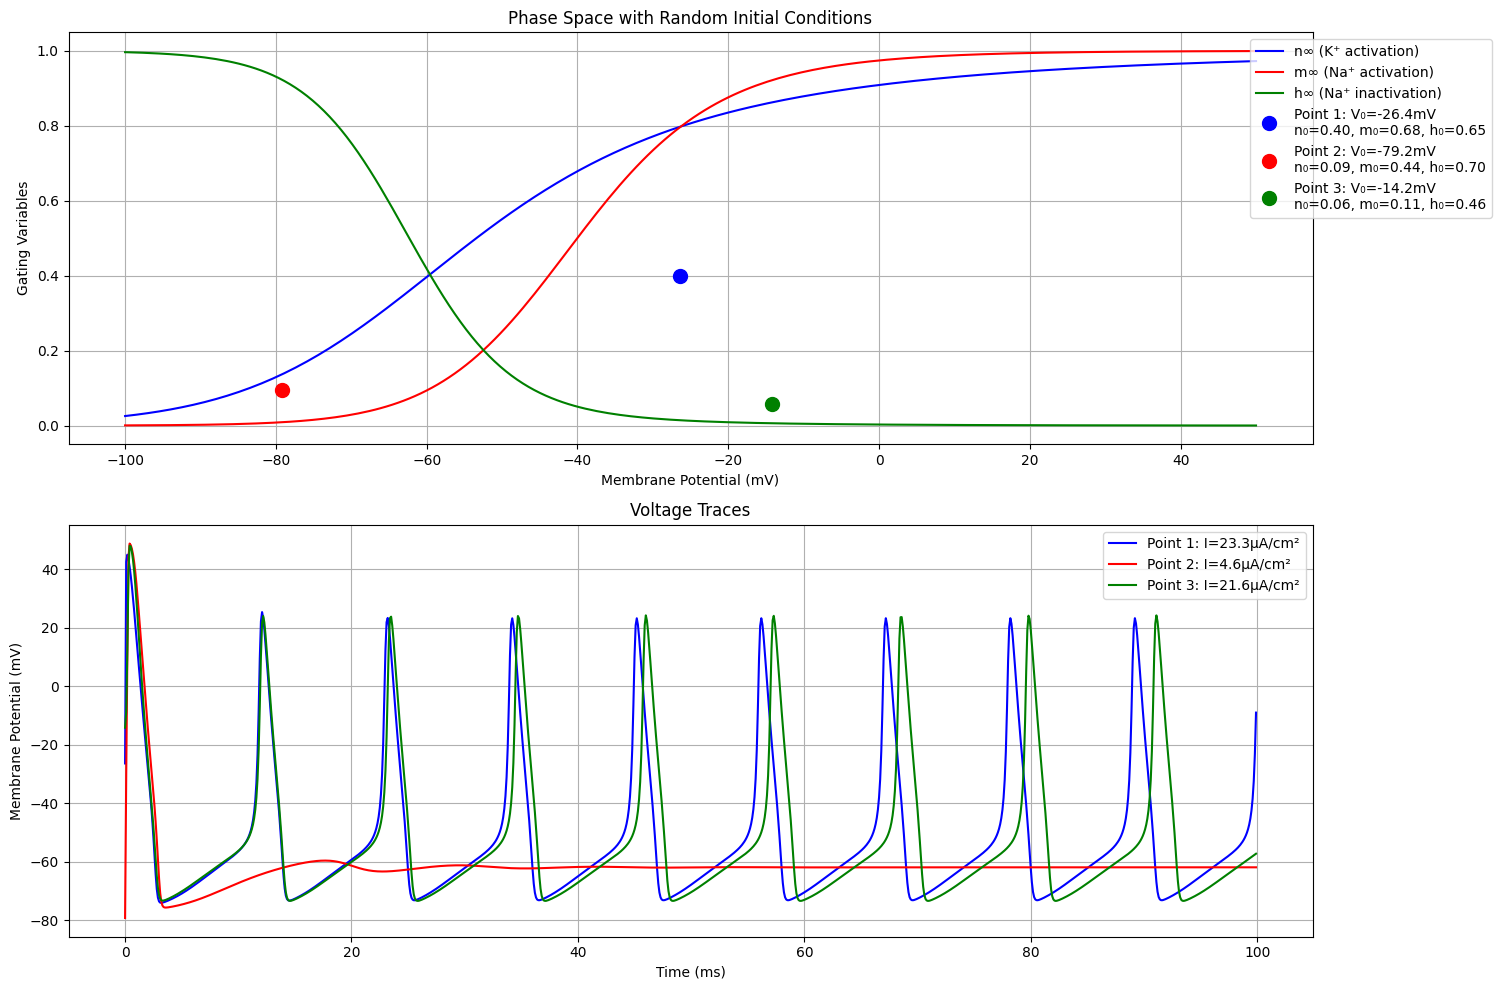

In [37]:
if __name__ == ")__main__":
    analyze_key_points() 